In [226]:
import pyspark as ps
import pyspark.sql.functions as f
from pyspark import SQLContext
from pyspark.sql.types import IntegerType, DateType, TimestampType
from datetime import datetime
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
spark = (ps.sql.SparkSession.builder 
        .master("local[4]") 
        .appName("sparkSQL exercise") 
        .getOrCreate()
        )
sc = spark.sparkContext

In [3]:
sc

<SparkContext master=local[4] appName=sparkSQL exercise>

In [4]:
sqlContext = SQLContext(sc)

In [5]:
df = sqlContext.read.csv("uk100.csv", header=True)

In [6]:
df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- rank: string (nullable = true)
 |-- last_week_rank: string (nullable = true)
 |-- hmm: string (nullable = true)
 |-- title: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- label: string (nullable = true)
 |-- peak_rank: string (nullable = true)
 |-- weeks_on_chart: string (nullable = true)
 |-- week_of: string (nullable = true)



In [7]:
df.createOrReplaceTempView('test')

In [8]:
spark.sql('''SELECT *
            FROM test
            LIMIT 30
            ''').show()

+---+----+--------------+--------+--------------------+--------------------+--------------------+---------+--------------+----------------+
|_c0|rank|last_week_rank|     hmm|               title|              artist|               label|peak_rank|weeks_on_chart|         week_of|
+---+----+--------------+--------+--------------------+--------------------+--------------------+---------+--------------+----------------+
|  0|   1|            11|        |               RIVER|      ELLIE GOULDING|             POLYDOR|        1|             5|December 27 2019|
|  1|   2|             8|        |ALL I WANT FOR CH...|        MARIAH CAREY|            COLUMBIA|        2|            99|December 27 2019|
|  2|   3|             5|        |      LAST CHRISTMAS|                WHAM|                 RCA|        2|            64|December 27 2019|
|  3|   4|            14|        |FAIRYTALE OF NEW ...|POGUES FT KIRSTY ...|         WARNER BROS|        2|            99|December 27 2019|
|  4|   5|          

## Drop unneeded columns and cast the rest to the correct types.

In [10]:
df = df.drop('_c0')
df = df.drop('hmm')

for col in df.columns:
    df = df.withColumn(col, f.lower(f.col(col)))

df = df.withColumn("rank", df["rank"].cast(IntegerType()))
df = df.withColumn("peak_rank", df["peak_rank"].cast(IntegerType()))
df = df.withColumn("weeks_on_chart", df["weeks_on_chart"].cast(IntegerType()))

def to_date(x):
    return datetime.strptime(x, '%B %d %Y')
change_to_datetype = f.udf(lambda y: to_date(y), DateType())

df = df.withColumn("week_of", change_to_datetype('week_of'))

In [11]:
df.printSchema()

root
 |-- rank: integer (nullable = true)
 |-- last_week_rank: string (nullable = true)
 |-- title: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- label: string (nullable = true)
 |-- peak_rank: integer (nullable = true)
 |-- weeks_on_chart: integer (nullable = true)
 |-- week_of: date (nullable = true)



In [12]:
df.createOrReplaceTempView('test')

## Total Count

In [13]:
spark.sql('''
        SELECT COUNT(*)
        FROM test
        ''').show()

+--------+
|count(1)|
+--------+
|   26000|
+--------+



In [38]:
spark.sql('''
        SELECT *
        FROM test
        ''').show()

+----+--------------+--------------------+--------------------+--------------------+---------+--------------+----------+
|rank|last_week_rank|               title|              artist|               label|peak_rank|weeks_on_chart|   week_of|
+----+--------------+--------------------+--------------------+--------------------+---------+--------------+----------+
|   1|            11|               river|      ellie goulding|             polydor|        1|             5|2019-12-27|
|   2|             8|all i want for ch...|        mariah carey|            columbia|        2|            99|2019-12-27|
|   3|             5|      last christmas|                wham|                 rca|        2|            64|2019-12-27|
|   4|            14|fairytale of new ...|pogues ft kirsty ...|         warner bros|        2|            99|2019-12-27|
|   5|             2|              own it|stormzy/ed sheera...|      atlantic/merky|        2|             5|2019-12-27|
|   6|            16|merry chris

## Count of distinct titles (songs with same names included)

In [15]:
spark.sql('''
        SELECT COUNT(DISTINCT title)
        FROM test
        ''').show()

+---------------------+
|count(DISTINCT title)|
+---------------------+
|                 2416|
+---------------------+



## Number of distinct titles that have reached rank 1

In [16]:
spark.sql('''
        SELECT COUNT(DISTINCT title)
        FROM test
        WHERE rank == 1''').show()

+---------------------+
|count(DISTINCT title)|
+---------------------+
|                   77|
+---------------------+



## Number of unique songs

In [26]:
num_unique_songs = spark.sql('''
        SELECT artist, title
        FROM test
        GROUP BY artist, title''')

In [27]:
num_unique_songs.count()

2605

In [18]:
spark.sql('''
        SELECT COUNT(*)
        FROM(
            SELECT artist, title
            FROM test
            GROUP BY artist, title)
        ''').show()

+--------+
|count(1)|
+--------+
|    2605|
+--------+



## How many weeks did these songs stay at rank 1

In [28]:
spark.sql('''
            SELECT DISTINCT artist, title, COUNT(*) as num_weeks, MIN(week_of)
            FROM test
            WHERE rank == 1
            GROUP BY 1, 2
            ORDER BY 3 DESC
            ''').show()

+--------------------+--------------------+---------+------------+
|              artist|               title|num_weeks|min(week_of)|
+--------------------+--------------------+---------+------------+
|drake ft wizkid &...|           one dance|       15|  2016-04-15|
|          ed sheeran|        shape of you|       14|  2017-01-13|
|           tones & i|        dance monkey|       11|  2019-10-04|
|luis fonsi/daddy ...|   despacito (remix)|       11|  2017-05-12|
|        clean bandit|            rockabye|        9|  2016-11-11|
|               drake|          god's plan|        9|  2018-01-26|
|ed sheeran & just...|        i don't care|        8|  2019-05-17|
|calvin harris & d...|            one kiss|        8|  2018-04-20|
|       lewis capaldi|   someone you loved|        7|  2019-03-01|
|       justin bieber|       love yourself|        6|  2015-12-04|
|shawn mendes/cami...|            senorita|        6|  2019-07-12|
|       ariana grande|        thank u next|        6|  2018-11

## Total number of appearances on the top 100, in order

In [31]:
spark.sql('''
            SELECT DISTINCT artist, title, COUNT(*) as num_weeks, MIN(week_of)
            FROM test
            WHERE peak_rank == 1
            GROUP BY 1,2
            ORDER BY 3 DESC
            ''').show()

+--------------------+-------------------+---------+------------+
|              artist|              title|num_weeks|min(week_of)|
+--------------------+-------------------+---------+------------+
|          ed sheeran|       shape of you|       97|  2017-01-13|
|          ed sheeran|  thinking out loud|       90|  2015-01-11|
|          ed sheeran|            perfect|       81|  2017-12-08|
|         george ezra|            shotgun|       74|  2018-06-29|
|mark ronson ft br...|        uptown funk|       72|  2015-01-11|
|luis fonsi/daddy ...|  despacito (remix)|       71|  2017-05-12|
|       justin bieber|              sorry|       65|  2015-11-20|
|drake ft wizkid &...|          one dance|       64|  2016-04-15|
|       justin bieber|      love yourself|       62|  2015-12-04|
|       justin bieber|   what do you mean|       62|  2015-09-04|
|            dua lipa|          new rules|       61|  2017-08-18|
|       years & years|               king|       59|  2015-03-08|
|lady gaga

## Average number of weeks in the top 100 (songs that hit rank 1)

In [33]:
spark.sql('''
            SELECT AVG(num_weeks)
            FROM (SELECT DISTINCT title, COUNT(*) as num_weeks, MIN(week_of)
                    FROM test
                    WHERE peak_rank == 1
                    GROUP BY 1
                    ORDER BY 2 DESC)
            ''').show()

+------------------+
|    avg(num_weeks)|
+------------------+
|26.708661417322833|
+------------------+



## Average rank for the song "Shape of You" by Ed Sheeran

In [43]:
spark.sql('''
            SELECT ROUND(AVG(rank),2), MAX(weeks_on_chart)
            FROM test
            WHERE title = "shape of you"
            ''').show()

+-----------------------------------+-------------------+
|round(avg(CAST(rank AS BIGINT)), 2)|max(weeks_on_chart)|
+-----------------------------------+-------------------+
|                              42.52|                 97|
+-----------------------------------+-------------------+



## Average rank and number of weeks on chart

In [ ]:
spark.sql('''
            SELECT AVG()''')

In [97]:
spark.sql('''
            SELECT title, artist, COUNT(*), ROUND(AVG(rank),2), MIN(week_of) as week_entered
            FROM test
            GROUP BY 1,2
            ORDER BY 3 DESC
            ''').show()

+--------------------+--------------------+--------+-----------------------------------+------------+
|               title|              artist|count(1)|round(avg(CAST(rank AS BIGINT)), 2)|week_entered|
+--------------------+--------------------+--------+-----------------------------------+------------+
|             perfect|          ed sheeran|     110|                              48.09|  2017-03-10|
|       mr brightside|             killers|     105|                              84.86|  2015-04-19|
|        shape of you|          ed sheeran|      97|                              42.52|  2017-01-13|
|   thinking out loud|          ed sheeran|      90|                              56.27|  2015-01-11|
|          chandelier|                 sia|      87|                              64.46|  2015-01-11|
|             shotgun|         george ezra|      87|                              35.99|  2018-03-30|
|             lean on|major lazer ft mo...|      79|                              

In [92]:
new_songs_2015_2019 = spark.sql('''
            SELECT *
            FROM (SELECT title, artist, COUNT(*), ROUND(AVG(rank),2), MIN(week_of) as week_entered
                FROM test
                GROUP BY 1,2
                ORDER BY 3 DESC)
            WHERE week_entered > "2015-01-11"''')

In [93]:
new_songs_2015_2019.createOrReplaceTempView('test2')

In [94]:
spark.sql('''
            SELECT COUNT(*)
            FROM test2''').show()

+--------+
|count(1)|
+--------+
|    2505|
+--------+



In [95]:
spark.sql('''
            SELECT *
            FROM test2''').show()

+--------------------+--------------------+--------+-----------------------------------+------------+
|               title|              artist|count(1)|round(avg(CAST(rank AS BIGINT)), 2)|week_entered|
+--------------------+--------------------+--------+-----------------------------------+------------+
|             perfect|          ed sheeran|     110|                              48.09|  2017-03-10|
|       mr brightside|             killers|     105|                              84.86|  2015-04-19|
|        shape of you|          ed sheeran|      97|                              42.52|  2017-01-13|
|             shotgun|         george ezra|      87|                              35.99|  2018-03-30|
|             lean on|major lazer ft mo...|      79|                              45.92|  2015-03-08|
|           let it go|           james bay|      77|                              65.03|  2015-03-29|
|          this is me|settle/greatest s...|      75|                              

In [53]:
spark.sql('''
            SELECT AVG(count)
            FROM (SELECT title, artist, COUNT(*) as count
                FROM test
                GROUP BY 1,2
                HAVING count > 1
                ORDER BY 3)
            ''').show()

+------------------+
|        avg(count)|
+------------------+
|13.223092998955067|
+------------------+



In [ ]:
spark.sql()

## Number of appearances by label

In [98]:
spark.sql('''
            SELECT label, COUNT(*)
            FROM test
            GROUP BY 1
            ORDER BY 2 DESC
            ''').show()

+--------------------+--------+
|               label|count(1)|
+--------------------+--------+
|            atlantic|    2055|
|            columbia|    1613|
|          interscope|    1493|
|             polydor|    1220|
|                 rca|    1099|
|              virgin|     924|
|              asylum|     911|
|                 emi|     830|
|          syco music|     821|
|    republic records|     817|
|          parlophone|     791|
|         warner bros|     653|
|              island|     650|
|cash money/republ...|     650|
|             capitol|     612|
|             def jam|     519|
|                epic|     471|
|   ministry of sound|     466|
|            positiva|     413|
|          relentless|     360|
+--------------------+--------+
only showing top 20 rows



In [99]:
spark.sql('''
            SELECT COUNT(DISTINCT label)
            FROM test
            ''').show()

+---------------------+
|count(DISTINCT label)|
+---------------------+
|                  408|
+---------------------+



## Average rank of each label

In [101]:
spark.sql('''
            SELECT label, COUNT(DISTINCT title) AS num_songs, ROUND(AVG(rank),2) AS avg_rank
            FROM test
            GROUP BY 1
            ORDER BY 2 DESC
            ''').show()

+--------------------+---------+--------+
|               label|num_songs|avg_rank|
+--------------------+---------+--------+
|          interscope|      171|   51.51|
|                 rca|      136|   53.36|
|            columbia|      134|   48.64|
|            atlantic|      129|   47.02|
|              virgin|      117|   54.65|
|             polydor|      110|   50.31|
|              island|       90|   54.77|
|          syco music|       80|   46.77|
|          parlophone|       79|   51.33|
|cash money/republ...|       78|   50.38|
|                 emi|       76|   47.93|
|             def jam|       69|    54.3|
|         warner bros|       60|   47.58|
|    republic records|       59|   43.67|
|             capitol|       48|   48.49|
|              asylum|       43|   48.22|
|                epic|       42|   53.03|
|   ministry of sound|       34|   46.21|
| republic records/xo|       33|   47.52|
|          relentless|       26|   54.46|
+--------------------+---------+--

In [102]:
spark.sql('''
            SELECT label, COUNT(DISTINCT title) AS num_songs, ROUND(AVG(rank),2) AS avg_rank
            FROM test
            GROUP BY 1
            HAVING num_songs >15
            ORDER BY 3
            ''').show(50, False)

+---------------------------+---------+--------+
|label                      |num_songs|avg_rank|
+---------------------------+---------+--------+
|republic records           |59       |43.67   |
|positiva                   |22       |44.21   |
|merky                      |16       |45.04   |
|ministry of sound          |34       |46.21   |
|warner records             |16       |46.38   |
|syco music                 |80       |46.77   |
|atlantic                   |129      |47.02   |
|disruptor                  |16       |47.25   |
|republic records/xo        |33       |47.52   |
|warner bros                |60       |47.58   |
|emi                        |76       |47.93   |
|asylum                     |43       |48.22   |
|capitol                    |48       |48.49   |
|columbia                   |134      |48.64   |
|polydor                    |110      |50.31   |
|cash money/republic records|78       |50.38   |
|3 beat                     |19       |51.3    |
|parlophone         

## Average rank per label (without collabs)

In [104]:
spark.sql('''
            SELECT label, COUNT(DISTINCT title), ROUND(AVG(rank),2) AS avg_rank
            FROM test
            WHERE label NOT IN (SELECT label
                                FROM test
                                WHERE label like "%/%"
                                GROUP BY label)
            GROUP BY 1
            ORDER BY 2 DESC
            ''').show(20, False)

+-----------------+---------------------+--------+
|label            |count(DISTINCT title)|avg_rank|
+-----------------+---------------------+--------+
|interscope       |171                  |51.51   |
|rca              |136                  |53.36   |
|columbia         |134                  |48.64   |
|atlantic         |129                  |47.02   |
|virgin           |117                  |54.65   |
|polydor          |110                  |50.31   |
|island           |90                   |54.77   |
|syco music       |80                   |46.77   |
|parlophone       |79                   |51.33   |
|emi              |76                   |47.93   |
|def jam          |69                   |54.3    |
|warner bros      |60                   |47.58   |
|republic records |59                   |43.67   |
|capitol          |48                   |48.49   |
|asylum           |43                   |48.22   |
|epic             |42                   |53.03   |
|ministry of sound|34          

## Most appearances by artist

In [105]:
spark.sql('''
            SELECT DISTINCT artist, COUNT(*), ROUND(AVG(rank),2) AS avg_rank
            FROM test
            GROUP BY 1
            ORDER BY 2 DESC''').show()

+--------------+--------+--------+
|        artist|count(1)|avg_rank|
+--------------+--------+--------+
|    ed sheeran|     706|   49.83|
|         drake|     352|    49.4|
| justin bieber|     280|   47.48|
| ariana grande|     269|   39.33|
|   george ezra|     263|   48.57|
|    little mix|     244|   45.81|
|           sia|     244|   55.59|
|        weeknd|     228|   46.48|
|     sam smith|     216|   48.84|
|  shawn mendes|     213|   42.92|
|   jess glynne|     207|   44.33|
| years & years|     197|   50.62|
|  taylor swift|     189|   54.21|
|      dua lipa|     172|   41.03|
|     james bay|     169|   58.82|
| lewis capaldi|     158|   29.18|
|      coldplay|     157|   53.01|
|ellie goulding|     142|   45.52|
|       stormzy|     142|    49.3|
|  zara larsson|     142|   43.61|
+--------------+--------+--------+
only showing top 20 rows



## More Ed Sheeran

In [106]:
spark.sql('''
            SELECT title, COUNT(*), MIN(rank) as peak, MIN(week_of)
            FROM test
            WHERE artist = "ed sheeran"
            GROUP BY 1
            ORDER BY 2 DESC
            ''').show(30, False)

+------------------------------+--------+----+------------+
|title                         |count(1)|peak|min(week_of)|
+------------------------------+--------+----+------------+
|perfect                       |110     |1   |2017-03-10  |
|shape of you                  |97      |1   |2017-01-13  |
|thinking out loud             |90      |3   |2015-01-11  |
|photograph                    |73      |15  |2015-01-11  |
|castle on the hill            |53      |2   |2017-01-13  |
|bloodstream                   |38      |2   |2015-03-01  |
|galway girl                   |31      |2   |2017-03-10  |
|sing                          |23      |29  |2015-01-11  |
|supermarket flowers           |21      |8   |2017-03-10  |
|don't                         |20      |20  |2015-01-11  |
|happier                       |18      |6   |2017-03-10  |
|what do i know                |17      |9   |2017-03-10  |
|i see fire                    |15      |54  |2015-01-11  |
|new man                       |14      

In [107]:
spark.sql('''
            SELECT title, COUNT(*), MIN(rank) as peak, MIN(week_of)
            FROM test
            WHERE artist = "ed sheeran"
            GROUP BY 1
            HAVING peak < 6
            ORDER BY 2 DESC
            ''').show(20, False)

+--------------------------+--------+----+------------+
|title                     |count(1)|peak|min(week_of)|
+--------------------------+--------+----+------------+
|perfect                   |110     |1   |2017-03-10  |
|shape of you              |97      |1   |2017-01-13  |
|thinking out loud         |90      |3   |2015-01-11  |
|castle on the hill        |53      |2   |2017-01-13  |
|bloodstream               |38      |2   |2015-03-01  |
|galway girl               |31      |2   |2017-03-10  |
|new man                   |14      |5   |2017-03-10  |
|how would you feel (paean)|12      |2   |2017-02-24  |
+--------------------------+--------+----+------------+



In [108]:
spark.sql('''
            SELECT COUNT(DISTINCT title)
            FROM test
            WHERE artist = "ed sheeran"
            
            ''').show()

+---------------------+
|count(DISTINCT title)|
+---------------------+
|                   26|
+---------------------+



In [110]:
df.printSchema() #table = test
new_songs_2015_2019.printSchema() # table = test2

root
 |-- rank: integer (nullable = true)
 |-- last_week_rank: string (nullable = true)
 |-- title: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- label: string (nullable = true)
 |-- peak_rank: integer (nullable = true)
 |-- weeks_on_chart: integer (nullable = true)
 |-- week_of: date (nullable = true)

root
 |-- title: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- count(1): long (nullable = false)
 |-- round(avg(CAST(rank AS BIGINT)), 2): double (nullable = true)
 |-- week_entered: date (nullable = true)



## Number of new songs from 2015-2019

In [111]:
spark.sql('''
            SELECT COUNT(*)
            FROM test
            WHERE last_week_rank LIKE "%new%"
            ''').show()

+--------+
|count(1)|
+--------+
|    2340|
+--------+



In [114]:
new_songs_2015_2019_2 = spark.sql('''
            SELECT artist, title
            FROM test
            WHERE last_week_rank LIKE "%new%"
            ''')

In [115]:
new_songs_2015_2019_2.createOrReplaceTempView('test3')

In [116]:
new_songs_2015_2019_2.printSchema()

root
 |-- artist: string (nullable = true)
 |-- title: string (nullable = true)



In [121]:
spark.sql('''
            SELECT *
            FROM test3
            ''').show()

+--------------------+--------------------+
|              artist|               title|
+--------------------+--------------------+
|            jessie j|    man with the bag|
|          liam payne|all i want (for c...|
|               queen|thank god it's ch...|
|      chris de burgh|a spaceman came t...|
|             ladbaby|i love sausage rolls|
|stormzy ft headie...|            audacity|
|             stormzy|             lessons|
|        harry styles|             falling|
|       jarvis cocker|   running the world|
|        lil uzi vert| futsal shuffle 2020|
|             sidemen|            the gift|
|      jonas brothers| like it's christmas|
|      d-block europe|             darling|
|          juice wrld|             legends|
|         roddy ricch|             the box|
|        harry styles|           adore you|
|         john legend|happy christmas (...|
|                jay1|       million bucks|
|        bugzy malone|            december|
|camila cabello ft...|          

In [126]:
df.printSchema()
df.count()

root
 |-- rank: integer (nullable = true)
 |-- last_week_rank: string (nullable = true)
 |-- title: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- label: string (nullable = true)
 |-- peak_rank: integer (nullable = true)
 |-- weeks_on_chart: integer (nullable = true)
 |-- week_of: date (nullable = true)



26000

In [125]:
new_songs_2015_2019_2.printSchema()
new_songs_2015_2019_2.count()

root
 |-- artist: string (nullable = true)
 |-- title: string (nullable = true)



2340

In [146]:
new_df = spark.sql('''
            SELECT *
            FROM test
            LEFT SEMI JOIN test3
            ON test.title = test3.title AND test.artist = test3.artist''')

In [147]:
new_df.count()

22822

In [148]:
new_df.createOrReplaceTempView('test4')

In [149]:
spark.sql('''
            SELECT *
            FROM test4
            ''').show()

+----+--------------+--------------------+--------------------+--------------------+---------+--------------+----------+
|rank|last_week_rank|               title|              artist|               label|peak_rank|weeks_on_chart|   week_of|
+----+--------------+--------------------+--------------------+--------------------+---------+--------------+----------+
|   1|            11|               river|      ellie goulding|             polydor|        1|             5|2019-12-27|
|   5|             2|              own it|stormzy/ed sheera...|      atlantic/merky|        2|             5|2019-12-27|
|   9|            34|happy christmas (...|         john legend|            columbia|        9|             3|2019-12-27|
|  12|             3|       before you go|       lewis capaldi|                 emi|        2|             6|2019-12-27|
|  14|             4|     don't start now|            dua lipa|      warner records|        2|             8|2019-12-27|
|  16|             7|           

## Life of songs (ordered by first entrance date) with avg rank over life

In [159]:
spark.sql('''
            SELECT artist, title, COUNT(*) AS num_weeks, ROUND(AVG(rank),2) AS avg_rank, MIN(week_of) AS entrance_date
            FROM test4
            GROUP BY 1,2
            ORDER BY 5''').show()

+--------------------+--------------------+---------+--------+-------------+
|              artist|               title|num_weeks|avg_rank|entrance_date|
+--------------------+--------------------+---------+--------+-------------+
|kygo ft conrad se...|           firestone|       55|   46.56|   2015-01-11|
|           james bay|               scars|        9|   76.89|   2015-01-11|
|                 omi|         cheerleader|       16|   60.81|   2015-01-11|
|        fall out boy|        irresistible|        2|    75.5|   2015-01-11|
|fuse odg ft killb...|    thinking about u|        3|   80.67|   2015-01-11|
|              tulisa|  living without you|        1|    44.0|   2015-01-11|
|tchami ft kaleem ...|           promesses|        9|   43.33|   2015-01-11|
|noel gallagher's ...|ballad of the mig...|        4|   67.25|   2015-01-18|
|          rae morris|   under the shadows|        3|   66.33|   2015-01-18|
|        fall out boy|         uma thurman|        3|    83.0|   2015-01-18|

In [171]:
join1 = spark.sql('''
            SELECT artist, title, COUNT(*) AS num_weeks, ROUND(AVG(rank),2) AS avg_rank, MIN(week_of) AS entrance_date
            FROM test4
            GROUP BY 1,2
            ORDER BY 5''')

## starting rank

In [170]:
spark.sql('''
            SELECT artist, title, rank, week_of
            FROM test4
            WHERE weeks_on_chart = 1
            ORDER BY 4''').show()

+--------------------+--------------------+----+----------+
|              artist|               title|rank|   week_of|
+--------------------+--------------------+----+----------+
|                 omi|         cheerleader|  96|2015-01-11|
|           james bay|               scars|  63|2015-01-11|
|kygo ft conrad se...|           firestone|  97|2015-01-11|
|        fall out boy|        irresistible|  70|2015-01-11|
|tchami ft kaleem ...|           promesses|   7|2015-01-11|
|              tulisa|  living without you|  44|2015-01-11|
|fuse odg ft killb...|    thinking about u|  79|2015-01-11|
|        fall out boy|         uma thurman|  71|2015-01-18|
|noel gallagher's ...|ballad of the mig...|  75|2015-01-18|
|        all time low|something's gotta...|  84|2015-01-18|
|             prodigy|               nasty|  98|2015-01-18|
|        fall out boy|american beauty/a...|  89|2015-01-18|
|          rae morris|   under the shadows|  53|2015-01-18|
|    big sean ft e-40|i don't f**k with.

In [185]:
join2 = spark.sql('''
            SELECT artist, title, rank, week_of as entrance_date
            FROM test4
            WHERE weeks_on_chart = 1
            ORDER BY 4''')

## Join for final df???

In [188]:
left_join = join1.join(join2, ['title', 'artist', 'entrance_date'],how='left')

In [189]:
left_join.createOrReplaceTempView('test5')

In [192]:
spark.sql('''
            SELECT *
            FROM test5''').show()

+--------------------+--------------------+-------------+---------+--------+----+
|               title|              artist|entrance_date|num_weeks|avg_rank|rank|
+--------------------+--------------------+-------------+---------+--------+----+
|        irresistible|        fall out boy|   2015-01-11|        2|    75.5|  70|
|           promesses|tchami ft kaleem ...|   2015-01-11|        9|   43.33|   7|
|  living without you|              tulisa|   2015-01-11|        1|    44.0|  44|
|         cheerleader|                 omi|   2015-01-11|       16|   60.81|  96|
|           firestone|kygo ft conrad se...|   2015-01-11|       55|   46.56|  97|
|    thinking about u|fuse odg ft killb...|   2015-01-11|        3|   80.67|  79|
|               scars|           james bay|   2015-01-11|        9|   76.89|  63|
|american beauty/a...|        fall out boy|   2015-01-18|        3|    75.0|  89|
|               hotel|kid ink ft chris ...|   2015-01-18|        5|    53.4|  43|
|   under the sh

In [193]:
spark.sql('''
            SELECT *
            FROM test5
            ORDER BY num_weeks DESC''').show()

+--------------------+--------------------+-------------+---------+--------+----+
|               title|              artist|entrance_date|num_weeks|avg_rank|rank|
+--------------------+--------------------+-------------+---------+--------+----+
|             perfect|          ed sheeran|   2017-03-10|      110|   48.09|   4|
|        shape of you|          ed sheeran|   2017-01-13|       97|   42.52|   1|
|             shotgun|         george ezra|   2018-03-30|       87|   35.99|  35|
|             lean on|major lazer ft mo...|   2015-03-08|       79|   45.92|  77|
|          this is me|settle/greatest s...|   2018-01-05|       75|   40.84|  28|
|     shut up & dance|       walk the moon|   2015-06-07|       72|   54.63|  75|
|can't stop the fe...|   justin timberlake|   2016-05-13|       71|   46.94|   3|
|               sorry|       justin bieber|   2015-10-30|       68|   41.43|   2|
|            stitches|        shawn mendes|   2015-09-25|       67|   47.63|  97|
|           new 

In [208]:
num_per_month_test = spark.sql('''
            SELECT COUNT(*)
            FROM test5
            WHERE MONTH(entrance_date) = 1
            ''').collect()

In [215]:
num_per_month_test[0][0]

143

In [222]:
num_songs_per_month = []

In [223]:
def num_song_per_month(month):
    songs_per_month = spark.sql('''
                        SELECT COUNT(*)
                        FROM test5
                        WHERE MONTH(entrance_date) = {}
                        '''.format(month)).collect()
    return num_songs_per_month.append(songs_per_month[0][0])

In [224]:
for i in range(1,13):
    num_song_per_month(i)

In [229]:
num_songs_per_month

[143, 177, 249, 201, 241, 193, 168, 182, 215, 190, 243, 137]

In [230]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

(0, 280)

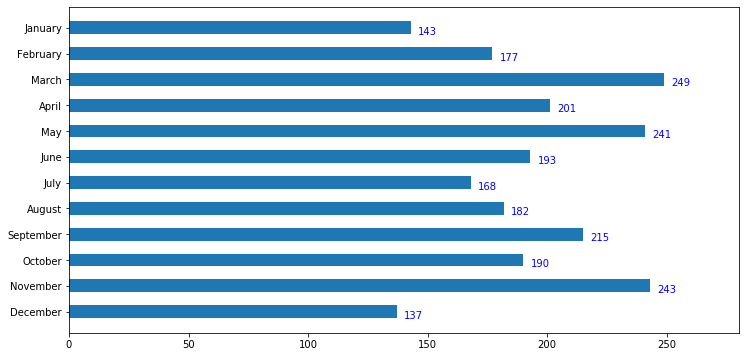

In [248]:
fig, ax = plt.subplots(figsize=(12,6))

ax.barh(months, num_songs_per_month, height=0.5)
ax.invert_yaxis()
for i, v in enumerate(num_songs_per_month):
    ax.text(v + 3, i + .25, str(v), color='blue')
ax.set_xlim(0,280)